<a href="https://colab.research.google.com/github/Smart-Pigs/Depth-Images/blob/main/Weight_Estimation_MRA_Approx_SimpleCNN_Cropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you have this folder as shortcut in your drive - /content/gdrive/MyDrive/Morota-video-data/ 

In [1]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [14]:
import pywt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

### Data Loading

In [3]:
#@markdown Select resolution of input dataset and weeks of data

Instantiate_New_Dataset = True #@param {type:"boolean"}
Refresh_Old_Dataset = False #@param {type:"boolean"}

if Instantiate_New_Dataset == True:
  !rm -rf Week*/

Resolution = "256"  #@param ['720', '512', '256']

if Refresh_Old_Dataset == False:
  if Resolution == "720":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_720.zip .
    !unzip -qq CROPPED_WEEK1-10_720.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "512":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_512.zip .
    !unzip -qq CROPPED_WEEK1-10_512.zip -d .
    !rm -rf *WEEK*.zip

  if Resolution == "256":
    !cp /content/gdrive/MyDrive/Morota-video-data/DEPTH_INDIVIDUAL/CROPPED/CROPPED_WEEK1-10_256.zip .
    !unzip -qq CROPPED_WEEK1-10_256.zip -d .
    !rm -rf *WEEK*.zip

### Mapping Table Input

In [28]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

#@markdown Select resolution of input dataset and weeks of data

Pig_Wise_Validation = True #@param {type:"boolean"}
Time_Wise_Validation = True #@param {type:"boolean"}

Pig_Test = "3384"  #@param ['3384', '3385', '3330', '3342']

Time_Test = "Week9_10"  #@param ['Week1_2', 'Week3_4', 'Week5_6', 'Week7_8','Week9_10']

final_map = pd.read_csv("/content/gdrive/MyDrive/Morota-video-data/final_mapping.csv")
weeks = final_map
weeks

def map_week(x):
    if x == 'Week1_2':
        return 'Week1/|Week2/'
    elif x == 'Week3_4':
        return 'Week3/|Week4/'
    elif x == 'Week5_6':
        return 'Week5/|Week6/'
    elif x == 'Week7_8':
        return 'Week7/|Week8/'
    elif x == 'Week9_10':
        return 'Week9/|Week10/'
    else:
        return None

if Pig_Wise_Validation == True and Time_Wise_Validation == True:
  print('Please select either Pig Wise Validation or Time Wise Validation')

else:
  if Pig_Wise_Validation == True and Time_Wise_Validation == False:
    weeks_train = weeks[weeks["Pig"] != int(Pig_Test)]
    weeks_test = weeks[weeks["Pig"] == int(Pig_Test)]

  if Pig_Wise_Validation == False and Time_Wise_Validation == True:
    weeks_train = weeks[~weeks['image_path'].str.contains(map_week(Time_Test))]
    weeks_test = weeks[weeks['image_path'].str.contains(map_week(Time_Test))]

  image_paths_train = weeks_train['image_path'].values
  labels_train = weeks_train['weight'].values
  image_paths_test = weeks_test['image_path'].values
  labels_test = weeks_test['weight'].values

  input_train_dataset = tf.data.Dataset.from_tensor_slices((image_paths_train, labels_train))
  input_test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))

  print("Number of elements in the train dataset:", tf.data.experimental.cardinality(input_train_dataset).numpy())
  print("Number of elements in the test dataset:", tf.data.experimental.cardinality(input_test_dataset).numpy())



Please select either Pig Wise Validation or Time Wise Validation


### Unaugmented




In [ ]:
IMG_SIZE = int(Resolution)
channels = 1

In [ ]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
#----------change gray scale and rgb----------------------------
    img = tf.image.rgb_to_grayscale(img)
#-------------------------------------------------------------------
    if int(Resolution) > IMG_SIZE:
      img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

In [ ]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

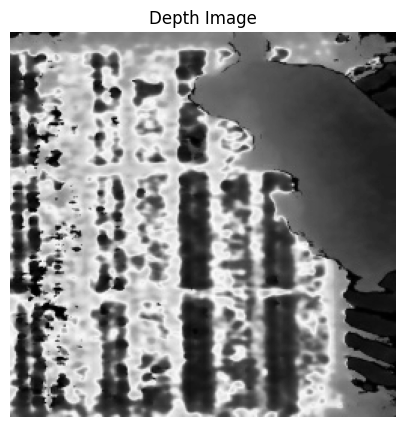

In [ ]:
def visualize_sample(dataset):
    for img_batch, label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()

        plt.figure(figsize=(10, 5))
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    flat = Flatten()(depth_pool2)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=depth_input, outputs=output)

    return model

In [ ]:
model = create_multi_input_cnn()

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depth_input (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0     

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
 47/544 [=>............................] - ETA: 2:33 - loss: 155.9731 - mae: 9.3353 - mape: 32.2170

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

209/209 [==============================] - 57s 272ms/step - loss: 27.3205 - mae: 3.8584 - mape: 11.0795
Test loss: 27.32050132751465
Test mean absolute error: 3.8583743572235107
Test mean absolute percentage error: 11.079508781433105


### MRA - Approximation Only (Feature Map Resized)




In [15]:
IMG_SIZE = int(Resolution)
channels = 1

In [16]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    if int(Resolution) > IMG_SIZE:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    wavelet_coeffs = tf.numpy_function(wavelet_transform, [img], tf.float32)
    wavelet_coeffs.set_shape((IMG_SIZE//2, IMG_SIZE//2, 1))

    return (img, wavelet_coeffs), label

def wavelet_transform(image, wavelet='haar'):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    coeffs = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs
    cA = cA.astype(np.float32) / 255.0
    cA = np.expand_dims(cA, axis=-1)
    return cA

In [17]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

(256, 256)
(128, 128)


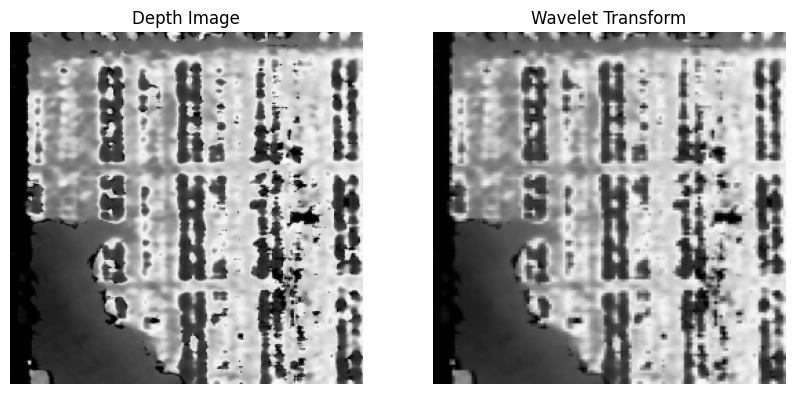

In [18]:
def visualize_sample(dataset):
    for (img_batch, wavelet_coeffs_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        wavelet_coeffs = wavelet_coeffs_batch[0].numpy().squeeze()
        print(img.shape)
        print(wavelet_coeffs.shape)

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wavelet_coeffs, cmap='gray')
        plt.title('Wavelet Transform')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [19]:
def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    wavelet_input = Input(shape=(IMG_SIZE//2, IMG_SIZE//2, 1), name="wavelet_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    wavelet_conv1 = Conv2D(16, (3, 3), activation="relu")(wavelet_input)
    wavelet_pool1 = MaxPooling2D((2, 2))(wavelet_conv1)
    wavelet_conv2 = Conv2D(32, (3, 3), activation="relu")(wavelet_pool1)
    wavelet_pool2 = MaxPooling2D((2, 2))(wavelet_conv2)

    wavelet_pool2_resized = tf.image.resize(wavelet_pool2, tf.shape(depth_pool2)[1:3])  # Resize the wavelet branch output to match the depth branch output

    concat = Concatenate()([depth_pool2, wavelet_pool2_resized])
    flat = Flatten()(concat)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, wavelet_input], outputs=output)

    return model

In [20]:
model = create_multi_input_cnn()

In [21]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 127, 127, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [23]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
498/498 [==============================] - 400s 774ms/step - loss: 43.3035 - mae: 4.4885 - mape: 15.8173 - val_loss: 52.9601 - val_mae: 5.6638 - val_mape: 15.6245
Epoch 2/50
498/498 [==============================] - 353s 708ms/step - loss: 11.6867 - mae: 2.5074 - mape: 9.0514 - val_loss: 48.9955 - val_mae: 5.4556 - val_mape: 15.2683
Epoch 3/50
498/498 [==============================] - 348s 699ms/step - loss: 8.5998 - mae: 2.1619 - mape: 7.8477 - val_loss: 43.5636 - val_mae: 4.9277 - val_mape: 13.5638
Epoch 4/50
498/498 [==============================] - 290s 582ms/step - loss: 7.3132 - mae: 2.0142 - mape: 7.3371 - val_loss: 49.6610 - val_mae: 5.4693 - val_mape: 15.2851
Epoch 5/50
498/498 [==============================] - 335s 672ms/step - loss: 6.0251 - mae: 1.8308 - mape: 6.6776 - val_loss: 41.9890 - val_mae: 4.8759 - val_mape: 13.5906
Epoch 6/50
498/498 [==============================] - 332s 667ms/step - loss: 5.4413 - mae: 1.7537 - mape: 6.4182 - val_loss: 37.1818 - v

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

### MRA - Approximation Only (Global Average Pooling)





In [ ]:
IMG_SIZE = int(Resolution)
channels = 1

In [ ]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    if int(Resolution) > IMG_SIZE:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    wavelet_coeffs = tf.numpy_function(wavelet_transform, [img], tf.float32)
    wavelet_coeffs.set_shape((IMG_SIZE//2, IMG_SIZE//2, 1))

    return (img, wavelet_coeffs), label

def wavelet_transform(image, wavelet='haar'):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    coeffs = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs
    cA = cA.astype(np.float32) / 255.0
    cA = np.expand_dims(cA, axis=-1)
    return cA

In [ ]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

(256, 256)
(128, 128)


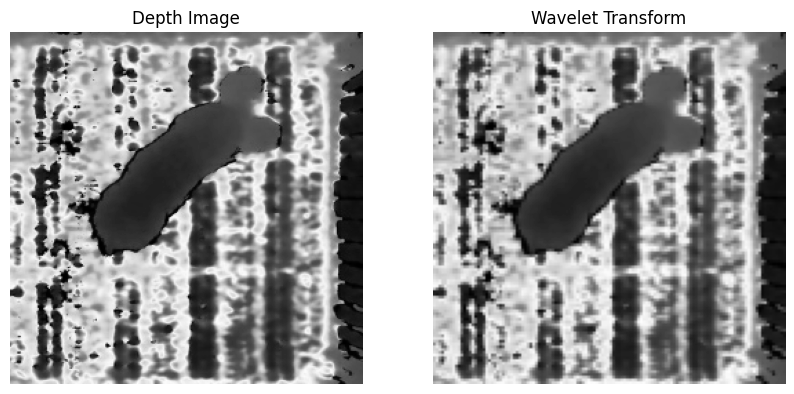

In [ ]:
def visualize_sample(dataset):
    for (img_batch, wavelet_coeffs_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        wavelet_coeffs = wavelet_coeffs_batch[0].numpy().squeeze()
        print(img.shape)
        print(wavelet_coeffs.shape)

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wavelet_coeffs, cmap='gray')
        plt.title('Wavelet Transform')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [ ]:
def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    wavelet_input = Input(shape=(IMG_SIZE//2, IMG_SIZE//2, 1), name="wavelet_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)
    depth_gap = GlobalAveragePooling2D()(depth_pool2)

    wavelet_conv1 = Conv2D(16, (3, 3), activation="relu")(wavelet_input)
    wavelet_pool1 = MaxPooling2D((2, 2))(wavelet_conv1)
    wavelet_conv2 = Conv2D(32, (3, 3), activation="relu")(wavelet_pool1)
    wavelet_pool2 = MaxPooling2D((2, 2))(wavelet_conv2)
    wavelet_gap = GlobalAveragePooling2D()(wavelet_pool2)

    concat = Concatenate()([depth_gap, wavelet_gap])
    dense1 = Dense(32, activation="relu")(concat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, wavelet_input], outputs=output)

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 127, 127, 16  0          ['conv2d_4[0][0]']               
                                )                                                           

In [ ]:
model = create_multi_input_cnn()

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 432s 762ms/step - loss: 36.3407 - mae: 4.2372 - mape: 14.7231 - val_loss: 32.2745 - val_mae: 4.3020 - val_mape: 12.4810
Epoch 2/50
544/544 [==============================] - 424s 779ms/step - loss: 11.4964 - mae: 2.4954 - mape: 8.8966 - val_loss: 25.6230 - val_mae: 3.8456 - val_mape: 11.5962
Epoch 3/50
338/544 [=================>............] - ETA: 1:40 - loss: 7.6661 - mae: 2.0344 - mape: 7.2706

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

### MRA - Approximation Only (Add)





In [ ]:
IMG_SIZE = int(Resolution)
channels = 1

In [ ]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    if int(Resolution) > IMG_SIZE:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    wavelet_coeffs = tf.numpy_function(wavelet_transform, [img], tf.float32)
    wavelet_coeffs.set_shape((IMG_SIZE//2, IMG_SIZE//2, 1))

    return (img, wavelet_coeffs), label

def wavelet_transform(image, wavelet='haar'):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    coeffs = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs
    cA = cA.astype(np.float32) / 255.0
    cA = np.expand_dims(cA, axis=-1)
    return cA

In [ ]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

(256, 256)
(128, 128)


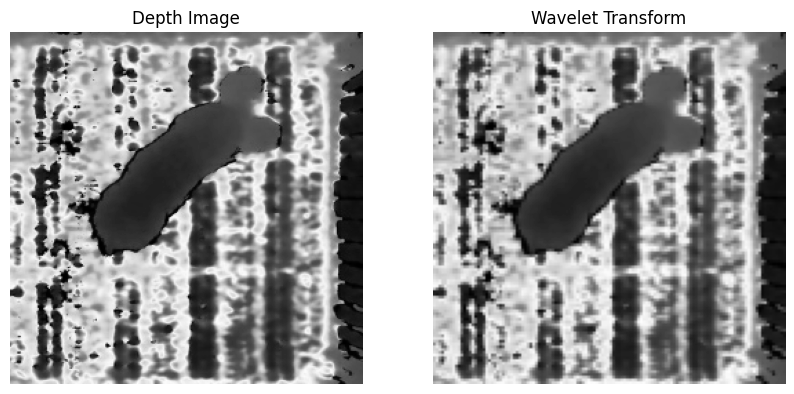

In [ ]:
def visualize_sample(dataset):
    for (img_batch, wavelet_coeffs_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        wavelet_coeffs = wavelet_coeffs_batch[0].numpy().squeeze()
        print(img.shape)
        print(wavelet_coeffs.shape)

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wavelet_coeffs, cmap='gray')
        plt.title('Wavelet Transform')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [ ]:
from tensorflow.keras.layers import Add, Multiply

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    wavelet_input = Input(shape=(IMG_SIZE//2, IMG_SIZE//2, 1), name="wavelet_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    wavelet_conv1 = Conv2D(16, (3, 3), activation="relu")(wavelet_input)
    wavelet_pool1 = MaxPooling2D((2, 2))(wavelet_conv1)
    wavelet_conv2 = Conv2D(32, (3, 3), activation="relu")(wavelet_pool1)
    wavelet_pool2 = MaxPooling2D((2, 2))(wavelet_conv2)

    wavelet_pool2_resized = tf.image.resize(wavelet_pool2, tf.shape(depth_pool2)[1:3])

    # For addition:
    combined_feature_maps = Add()([depth_pool2, wavelet_pool2_resized])

    flat = Flatten()(combined_feature_maps)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, wavelet_input], outputs=output)

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 127, 127, 16  0          ['conv2d_4[0][0]']               
                                )                                                           

In [ ]:
model = create_multi_input_cnn()

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 432s 762ms/step - loss: 36.3407 - mae: 4.2372 - mape: 14.7231 - val_loss: 32.2745 - val_mae: 4.3020 - val_mape: 12.4810
Epoch 2/50
544/544 [==============================] - 424s 779ms/step - loss: 11.4964 - mae: 2.4954 - mape: 8.8966 - val_loss: 25.6230 - val_mae: 3.8456 - val_mape: 11.5962
Epoch 3/50
338/544 [=================>............] - ETA: 1:40 - loss: 7.6661 - mae: 2.0344 - mape: 7.2706

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

### MRA - Approximation Only (Multiply)






In [ ]:
IMG_SIZE = int(Resolution)
channels = 1

In [ ]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    if int(Resolution) > IMG_SIZE:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    wavelet_coeffs = tf.numpy_function(wavelet_transform, [img], tf.float32)
    wavelet_coeffs.set_shape((IMG_SIZE//2, IMG_SIZE//2, 1))

    return (img, wavelet_coeffs), label

def wavelet_transform(image, wavelet='haar'):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    coeffs = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs
    cA = cA.astype(np.float32) / 255.0
    cA = np.expand_dims(cA, axis=-1)
    return cA

In [ ]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

(256, 256)
(128, 128)


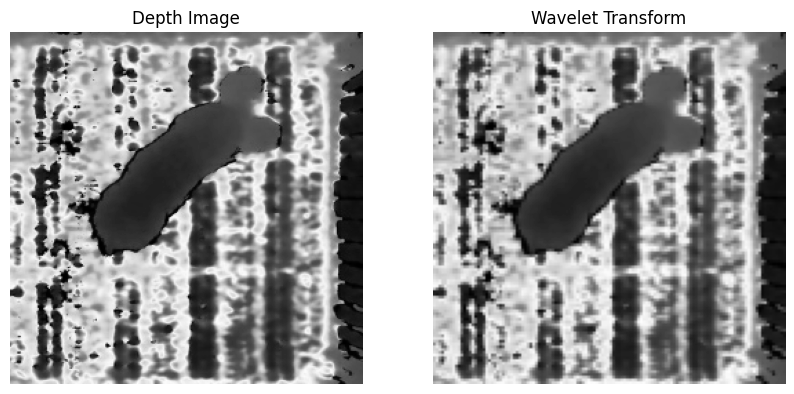

In [ ]:
def visualize_sample(dataset):
    for (img_batch, wavelet_coeffs_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        wavelet_coeffs = wavelet_coeffs_batch[0].numpy().squeeze()
        print(img.shape)
        print(wavelet_coeffs.shape)

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wavelet_coeffs, cmap='gray')
        plt.title('Wavelet Transform')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [ ]:
from tensorflow.keras.layers import Add, Multiply

def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    wavelet_input = Input(shape=(IMG_SIZE//2, IMG_SIZE//2, 1), name="wavelet_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    wavelet_conv1 = Conv2D(16, (3, 3), activation="relu")(wavelet_input)
    wavelet_pool1 = MaxPooling2D((2, 2))(wavelet_conv1)
    wavelet_conv2 = Conv2D(32, (3, 3), activation="relu")(wavelet_pool1)
    wavelet_pool2 = MaxPooling2D((2, 2))(wavelet_conv2)

    wavelet_pool2_resized = tf.image.resize(wavelet_pool2, tf.shape(depth_pool2)[1:3])

    # For multiplication
    combined_feature_maps = Multiply()([depth_pool2, wavelet_pool2_resized])

    flat = Flatten()(combined_feature_maps)
    dense1 = Dense(32, activation="relu")(flat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, wavelet_input], outputs=output)

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 127, 127, 16  0          ['conv2d_4[0][0]']               
                                )                                                           

In [ ]:
model = create_multi_input_cnn()

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
544/544 [==============================] - 432s 762ms/step - loss: 36.3407 - mae: 4.2372 - mape: 14.7231 - val_loss: 32.2745 - val_mae: 4.3020 - val_mape: 12.4810
Epoch 2/50
544/544 [==============================] - 424s 779ms/step - loss: 11.4964 - mae: 2.4954 - mape: 8.8966 - val_loss: 25.6230 - val_mae: 3.8456 - val_mape: 11.5962
Epoch 3/50
338/544 [=================>............] - ETA: 1:40 - loss: 7.6661 - mae: 2.0344 - mape: 7.2706

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)

### MRA - Approximation Only (Spatial Pyramid Pooling)






In [24]:
IMG_SIZE = int(Resolution)
channels = 1

In [25]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    if int(Resolution) > IMG_SIZE:
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0

    wavelet_coeffs = tf.numpy_function(wavelet_transform, [img], tf.float32)
    wavelet_coeffs.set_shape((IMG_SIZE//2, IMG_SIZE//2, 1))

    return (img, wavelet_coeffs), label

def wavelet_transform(image, wavelet='haar'):
    image = image.squeeze() * 255
    image = image.astype(np.uint8)
    coeffs = pywt.dwt2(image, wavelet)
    cA, (cH, cV, cD) = coeffs
    cA = cA.astype(np.float32) / 255.0
    cA = np.expand_dims(cA, axis=-1)
    return cA

In [26]:
batch_size = 128

train_dataset = input_train_dataset.shuffle(len(labels_train))
train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = input_test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

(256, 256)
(128, 128)


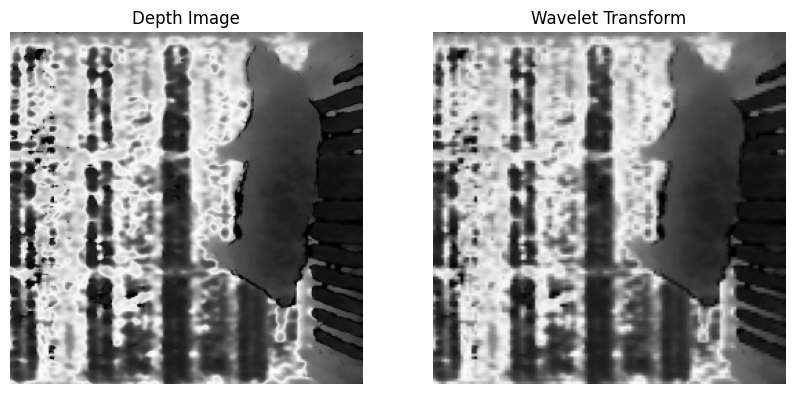

In [27]:
def visualize_sample(dataset):
    for (img_batch, wavelet_coeffs_batch), label_batch in dataset.take(1):
        img = img_batch[0].numpy().squeeze()
        wavelet_coeffs = wavelet_coeffs_batch[0].numpy().squeeze()
        print(img.shape)
        print(wavelet_coeffs.shape)

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Depth Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(wavelet_coeffs, cmap='gray')
        plt.title('Wavelet Transform')
        plt.axis('off')

        plt.show()

visualize_sample(train_dataset)

In [38]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class SpatialPyramidPooling(tf.keras.layers.Layer):
    def __init__(self, pool_list, **kwargs):
        super(SpatialPyramidPooling, self).__init__(**kwargs)
        self.pool_list = pool_list

    def call(self, x):
        pools = []
        x_shape = tf.shape(x)
        for p in self.pool_list:
            pool_size = (x_shape[1] // p, x_shape[2] // p)
            strides = (x_shape[1] // p, x_shape[2] // p)
            pool = tf.nn.max_pool2d(x, ksize=[1, *pool_size, 1], strides=[1, *strides, 1], padding='VALID')
            pool = tf.keras.layers.Flatten()(pool)
            pools.append(pool)
        spp = tf.keras.layers.Concatenate()(pools)
        return spp

    def compute_output_shape(self, input_shape):
        return input_shape[0], sum([p * p for p in self.pool_list])


def create_multi_input_cnn():
    depth_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="depth_input")
    wavelet_input = Input(shape=(IMG_SIZE//2, IMG_SIZE//2, 1), name="wavelet_input")

    depth_conv1 = Conv2D(16, (3, 3), activation="relu")(depth_input)
    depth_pool1 = MaxPooling2D((2, 2))(depth_conv1)
    depth_conv2 = Conv2D(32, (3, 3), activation="relu")(depth_pool1)
    depth_pool2 = MaxPooling2D((2, 2))(depth_conv2)

    wavelet_conv1 = Conv2D(16, (3, 3), activation="relu")(wavelet_input)
    wavelet_pool1 = MaxPooling2D((2, 2))(wavelet_conv1)
    wavelet_conv2 = Conv2D(32, (3, 3), activation="relu")(wavelet_pool1)
    wavelet_pool2 = MaxPooling2D((2, 2))(wavelet_conv2)

    depth_spp = SpatialPyramidPooling([1, 2, 4])(depth_pool2)
    wavelet_spp = SpatialPyramidPooling([1, 2, 4])(wavelet_pool2)

    concat = Concatenate()([depth_spp, wavelet_spp])
    dense1 = Dense(32, activation="relu")(concat)
    output = Dense(1)(dense1)

    model = Model(inputs=[depth_input, wavelet_input], outputs=output)

    return model

In [39]:
model = create_multi_input_cnn()

TypeError: ignored

In [37]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 depth_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 wavelet_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 254, 254, 16  160         ['depth_input[0][0]']            
                                )                                                           

In [34]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50


TypeError: ignored

In [ ]:
test_loss, test_mae, test_mape = model.evaluate(test_dataset)
print('Test loss:', test_loss)
print('Test mean absolute error:', test_mae)
print('Test mean absolute percentage error:', test_mape)